In [1]:
import numpy as np
np.random.seed(523)
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
def plot_roc (model, X, y):
    
    # model=lasso1
    # X = X_test_scaled
    # y = y_test

    # probabilities of ckd
    ckd_probs=model.predict_proba(X)[:,1]

    oneminusspec_list=[]
    sensitivity_list=[]

    threshes=np.linspace(0,1, 100)
    for thresh in threshes:
     
        # initialize the confusion matrix tally for this particular threshold
        TP=0
        FP=0
        FN=0
        TN=0
    
        # For every threshold, compute the confusion matrix values
        for obs_num in range(len(y)):
            if ckd_probs[obs_num]>=thresh:
                predict_sick=True
            else:
                predict_sick=False

            if y[obs_num]==1:
                sick=True
            else:
                sick=False

            if predict_sick and sick:
                TP += 1
            elif predict_sick and not sick:
                FP += 1
            elif not predict_sick and sick:
                FN += 1
            else:
                TN += 1

        # For every threshold, compute and record the oneminusspec
        # value and the sensitivity value
        sensitivity = TP / (TP + FN)
        specificity = TN / (TN + FP)
        oneminusspec = 1 - specificity

        oneminusspec_list.append(oneminusspec)
        sensitivity_list.append(sensitivity)


    oneminusspec_list=list(reversed(oneminusspec_list))
    sensitivity_list=list(reversed(sensitivity_list))

    oneminusspec_list
    sensitivity_list

    figure, ax = plt.subplots(figsize=(7,7))
    plt.plot(oneminusspec_list, sensitivity_list)
    x=np.linspace(0,1, num=50)
    y=x
    plt.plot(x,y, 'r')
    plt.plot()
    ax.set_xlabel("False positive rate", fontsize=20)
    ax.set_ylabel("Sensitivity", fontsize=20)

# Predicting whether a message is from a prolife or prochoice discussion group

## 1. TrainTestSplit 

In [3]:
df=pd.read_pickle('./abort_pickle')

In [4]:
X=df['body']
y =df['class']

# Pro-choice is Class 0
# Pro-life is Class 1

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=.3,
                                                   random_state=42)

In [6]:
y_train.shape

(6774,)

## 2. Naive Bayes Model

In [7]:
# This is the baseline accuracy score

baseline=y_train.value_counts().max()/y_train.shape[0]
baseline

0.5087097726601713

In [8]:
y_train.value_counts()

1    3446
0    3328
Name: class, dtype: int64

In [9]:
pipeline = Pipeline([
    
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('bayes', MultinomialNB())
])


In [10]:
hyperparameters={ 
                'tfidf__use_idf': [True],
                 'vect__max_df': [0.01],
                 'vect__ngram_range': [(1,2)]
                }

grid = GridSearchCV(pipeline, hyperparameters, cv=3)

In [11]:
_=grid.fit(X_train, y_train)

In [12]:
grid.best_params_

{'tfidf__use_idf': True, 'vect__max_df': 0.01, 'vect__ngram_range': (1, 2)}

In [13]:
grid.score(X_train, y_train)

0.9769707705934455

In [14]:
grid.score(X_test, y_test)

0.6952479338842975

In [15]:
tn, fp, fn, tp = confusion_matrix(y_test, grid.predict(X_test)).ravel()

In [16]:
# Specificity

tn/(fp+tn)

0.7202797202797203

In [17]:
# Sensitivity

tp/(fn+tp)

0.6709633649932157

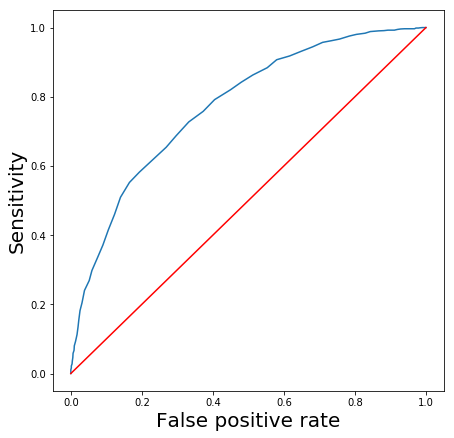

In [18]:
plot_roc(grid, X_test, y_test.ravel())

plt.savefig("./class2.png")


In [19]:
f1_score(y_test, grid.predict(X_test))

0.6908836884387006

In [20]:
vectorizer=CountVectorizer(max_df=0.01, ngram_range=(1, 2))

In [21]:
transformer=TfidfTransformer()

In [22]:
bayes=MultinomialNB()

In [23]:
one=vectorizer.fit_transform(X_train)

In [24]:
two=transformer.fit_transform(one)

In [25]:
bayes.fit(two, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [26]:
coefs=(pd.DataFrame(bayes.feature_log_prob_).T)
coefs=coefs.rename(columns={0:'prochoice log-odds', 1:'prolife log-odds'})
coefs['vocabulary']=vectorizer.get_feature_names()

In [27]:
coefs['diff']=coefs['prochoice log-odds']-coefs['prolife log-odds']

In [28]:
coefs['abs diff']=coefs['diff'].abs()

In [29]:
def label(x):
    if x>0:
        return "distinctively pro-choice"
    else:
        return "distinctively pro-life"

In [30]:
coefs['label']=coefs['diff'].map(label)

In [59]:
wordslist=coefs.sort_values(by='abs diff', ascending=False)[['vocabulary', 'abs diff', 'label']]

In [60]:
wordslist[:50]

,vocabulary,abs diff,label
148413,randy,1.778422,distinctively pro-life
21075,beth,1.635218,distinctively pro-life
178417,surrogacy,1.443575,distinctively pro-life
10994,anti choicers,1.432776,distinctively pro-choice
10992,anti choice,1.339554,distinctively pro-choice
135143,personality,1.328358,distinctively pro-choice
74605,gay couple,1.259360,distinctively pro-life
82941,headline,1.253772,distinctively pro-life
71069,flu,1.228422,distinctively pro-choice
111207,march life,1.216869,distinctively pro-life


In [56]:
pro_choice_vocab=coefs.sort_values(by='prochoice log-odds', ascending=False)[['vocabulary', 'prochoice log-odds']]
pro_choice_vocab[:50]

,vocabulary,prochoice log-odds
10992,anti choice,-10.094406
75629,get pregnant,-10.528393
73426,fuck,-10.549367
188185,troll,-10.581793
177042,suicide,-10.592804
54518,donation,-10.598204
194894,viability,-10.600627
171471,species,-10.604625
72436,foster,-10.605870
73485,fucking,-10.624263


In [54]:
prolife_vocab=coefs.sort_values(by='prolife log-odds', ascending=False)[['vocabulary', 'prolife log-odds']]
prolife_vocab[:50]

,vocabulary,prolife log-odds
21458,bible,-10.217517
195153,video,-10.406597
6997,agreed,-10.515448
148413,randy,-10.559191
1711,abortion rights,-10.580398
197561,war,-10.580610
139961,pp,-10.589300
76694,glad,-10.598635
165245,shame,-10.605940
111194,march,-10.648511


In [33]:
pro_life_vocab=list(coefs.sort_values(by='prolife log-odds', ascending=False)['vocabulary'])[:50]

In [34]:
pro_choice_vocab

['anti choice',
 'get pregnant',
 'fuck',
 'troll',
 'suicide',
 'donation',
 'viability',
 'species',
 'foster',
 'fucking',
 'effective',
 'give birth',
 'kidney',
 'pill',
 'op',
 'pp',
 'friend',
 'flu',
 'mistake',
 'late term',
 'fetus human',
 'counter',
 'dna',
 'wtf',
 'nice',
 'infant',
 'plan',
 'defend',
 'business',
 'begins conception',
 'right choose',
 'labor',
 'persons',
 'nah',
 'month',
 'definitions',
 'feelings',
 'unwanted pregnancy',
 'pregnant women',
 'woman body',
 'twins',
 'prolifer',
 'adopt',
 'syndrome',
 'white',
 'fertilized',
 'compassion',
 'church',
 'biology',
 'consciousness']

## 3. Random Forest Model

In [36]:
pipeline2 = Pipeline([
    
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('forest', RandomForestClassifier())
])


In [37]:
hyperparameters={ 
                'tfidf__use_idf': [True],
                 'vect__max_df': [0.01],
                 'vect__ngram_range': [(1,2)],
                'forest__min_samples_split': [2, 10, 20],
                'forest__min_impurity_decrease':[0],
                'forest__max_depth':[200, 300, 400]
                }

grid = GridSearchCV(pipeline2, hyperparameters, cv=3)

In [38]:
_=grid.fit(X_train, y_train)

In [39]:
grid.best_params_

{'forest__max_depth': 400,
 'forest__min_impurity_decrease': 0,
 'forest__min_samples_split': 10,
 'tfidf__use_idf': True,
 'vect__max_df': 0.01,
 'vect__ngram_range': (1, 2)}

In [40]:
grid.score(X_test, y_test)

0.6229338842975206

In [41]:
grid.score(X_train, y_train)

0.8454384410983171

In [42]:
f1_score(y_test, grid.predict(X_test))

0.6654445462878094

Random forest doesn't seem to offer much benefit over Naive Bayes.